In [1]:
import os
from est_lib.util.obspy_util import *
from est_lib.util.obspy_plot import ray_plot
from obspy import UTCDateTime as dt

In [2]:
from tqdm.notebook import tqdm

In [3]:
test_name = "demo-file-retriever".format(str(dt.now()).replace(':','.'))
folder = os.path.abspath(os.path.join('..','..','Demo-Retriever'))
writer_path = folder

In [4]:
# Save
filepath = os.path.abspath(writer_path)

In [5]:
sta_list = [
    'BFSB','CBB','CLRS','HOLB','HOPB','LLLB','NLLB','NTKA','PACB','PHC','PTRF','SNB','SYMB','VGZ','WOSB'
]
cha_list = ['HNE','HNN','HNZ']

In [6]:
inv = inventory_retriever(network="CN",
                              sta_list=sta_list,
                              level='response')

# Mag 6.5
lat = 49.051
lon = -129.8831
time = "2018-10-22T06:22:45"
mag = ('6.5','mww')

sb = 10*60
sa = 25*60

event = (mag[0],lat,lon,time)

streams = stream_retriever(event_time = dt(event[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list,
                          channel_list=cha_list)

In [7]:
# Filter Station List to retain Stations with Trace Data
temp_sta_list = sta_list.copy()
count = 0
with open(os.path.join(filepath,"trace_metadata.txt"),'w') as f:
    for i,sta in enumerate(temp_sta_list):
        score = 0
        for j,cha in enumerate(cha_list):
            temp = streams.select(station=sta,channel=cha)
            try:
                #print(sta+'-'+cha)
                f.write('{}\n'.format(temp[0]))
                count+=1
            except(IndexError):
                score+=1
        if score > 0:
            sta_list.remove(sta)

print("Count = {}".format(count))
print(sta_list)
print(len(sta_list))

Count = 33
['BFSB', 'CBB', 'HOLB', 'HOPB', 'NLLB', 'PACB', 'PHC', 'PTRF', 'SNB', 'SYMB', 'VGZ']
11


In [8]:
streams.filter(type='bandpass',freqmin=0.01,freqmax=4)

33 Trace(s) in Stream:

CN.BFSB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
...
(31 other traces)
...
CN.VGZ..HNZ | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [9]:
streams.remove_response(inventory=inv)

33 Trace(s) in Stream:

CN.BFSB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
...
(31 other traces)
...
CN.VGZ..HNZ | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [10]:
# Visualize
plot_stream = streams.select()
print(plot_stream.__str__(extended=True))

33 Trace(s) in Stream:
CN.BFSB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.BFSB..HNN | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.BFSB..HNZ | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.CBB..HNE  | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.CBB..HNN  | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.CBB..HNZ  | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.HOLB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.HOLB..HNN | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.HOLB..HNZ | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.HOPB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 10

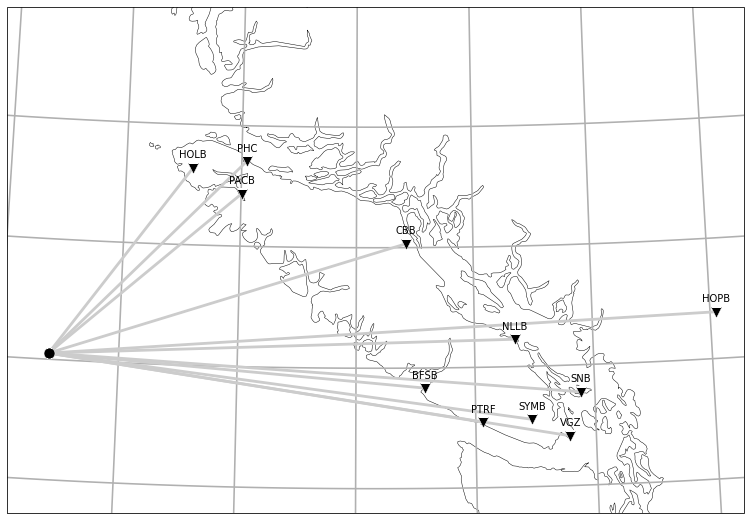

In [11]:
ev_fig = ray_plot(
    ev_lat=lat,
    ev_lon=lon,
    min_lat=47.8,
    max_lat=52.,
    min_lon=-130.5,
    max_lon=-121,
    streams=streams,
    inventory=inv)

In [12]:
# Metadata Printer
def dump_meta(inv,sta_list,f_path):
    with open(f_path,'w') as f:
        f.write("Station\t\tLatitude\tLongitude\n")
        f.write("=======\t\t========\t=========")
        for sta in sta_list:
            temp = inv.select(station=sta)
            station = temp[0][0]
            f.write("\n{}\t\t{}\t\t{}".format(station.code,station.latitude,station.longitude))
        f.write("\n")
            
def dump_event_meta(ev,sb,sa,f_path):
    start = str(dt(ev[3])-sb)
    end = str(dt(start)+sa)
    with open(f_path,'w') as f:
        f.write("Magnitude\tLatitude\tLongitude\tTrace-Start (UTC)\t\tTrace-End (UTC)\n")
        f.write("==========\t========\t=========\t=================\t\t===============\n")
        f.write("{}\t\t{}\t\t{}\t{}\t{}".format(ev[0],ev[1],ev[2],start,end))
        f.write("\n")

In [13]:
dump_meta(inv,sta_list,os.path.join(filepath,'station_metadata.txt'))
with open(os.path.join(filepath,'station_metadata.txt'),'r') as f:
    print(f.read())

Station		Latitude	Longitude
=======		========	=========
BFSB		48.8336		-125.136
CBB		50.0315		-125.3652
HOLB		50.6402		-128.1331
HOPB		49.3872		-121.4206
NLLB		49.2271		-123.9882
PACB		50.4355		-127.4925
PHC		50.7067		-127.433
PTRF		48.5442		-124.4131
SNB		48.7751		-123.1723
SYMB		48.5593		-123.7989
VGZ		48.4131		-123.3251



In [14]:
dump_event_meta(event,sb,sa,os.path.join(filepath,'event_metadata.txt'))
with open(os.path.join(filepath,'event_metadata.txt'),'r') as f:
    print(f.read())

Magnitude	Latitude	Longitude	Trace-Start (UTC)		Trace-End (UTC)
==========	========	=========	=================		===============
6.5		49.051		-129.8831	2018-10-22T06:12:45.000000Z	2018-10-22T06:37:45.000000Z



In [16]:
print(streams[0].stats.station)
print(streams[0].stats.sampling_rate)
print(streams[0].stats.starttime)
print(streams[0].stats.endtime)
print(streams[0].stats.npts)

BFSB
100.0
2018-10-22T06:12:45.000000Z
2018-10-22T06:37:45.000000Z
150001


In [17]:
print(streams[0].stats.starttime.time)
print(str(streams[0].stats.starttime.date).replace('-','.'))
print(str(streams[0].stats.starttime.date.isoformat()).replace('-','.'))

06:12:45
2018.10.22
2018.10.22


In [18]:
def demo_data_writer(streams,f_path,sta_list,cha_list):
    for s,sta in tqdm(enumerate(sta_list)):
        temp = streams.select(station=sta)
        # file_management
        f_dest = os.path.join(f_path,'{}.dat'.format(sta))
        with open(f_dest,'w') as f:
            # header
            assert sta == temp[0].stats.station
            f.write("Station_code\t{}\n".format(temp[0].stats.station))
            f.write("Sampling_rate\t{}\n".format(temp[0].stats.sampling_rate))
            f.write("Start_date\t{}\n".format(str(temp[0].stats.starttime.date).replace('-','.')))
            f.write("Start_time\t{}\n".format(temp[0].stats.starttime.time))
            f.write("Vertical (m/s^2)\tNorth (m/s^2)\t\tEast (m/s^2)\n")
            for i,(ud,ns,ew) in enumerate(zip(temp[2],temp[1],temp[0])):
                f.write("{}\t{}\t{}\n".format(ud,ns,ew))

In [19]:
demo_data_writer(streams,os.path.join(writer_path,'Data'),sta_list,cha_list)

0it [00:00, ?it/s]

In [20]:
def demo_data_reader(f_path):
    op = np.genfromtxt(f_path,skip_header=5)
    return op

In [21]:
#samp = stream_data_reader(os.path.join(filepath,'time_series_accelleration_data.npy'))
samp = demo_data_reader(os.path.join(writer_path,'Data','BFSB.dat'))
print(samp.shape)

(150001, 3)


In [22]:
# Check if Data is Packed Correctly
for i,sta in tqdm(enumerate(sta_list)):
    comp = demo_data_reader(os.path.join(writer_path,'Data','{}.dat'.format(sta)))
    count_down = 2
    for j,cha in enumerate(cha_list):
        temp = streams.select(station=sta,channel=cha)
        assert np.all(np.equal(temp[0].data,comp[:,count_down - j]))

0it [00:00, ?it/s]

In [23]:
import matplotlib.pyplot as plt

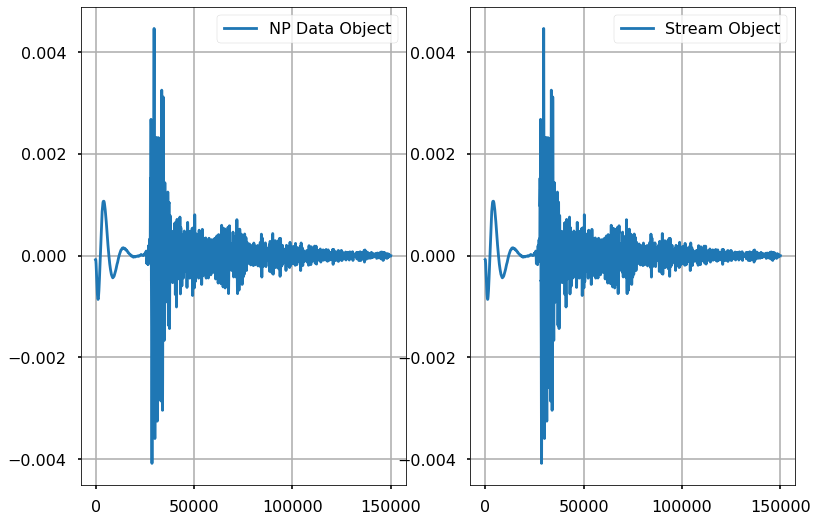

In [24]:
# Plot to Verify
# 7th Stream (2,0) --> CN.HOPB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:42:45.000000Z | 100.0 Hz, 180001 samples
# CN.HOLB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
samp  = demo_data_reader(os.path.join(writer_path,'Data','HOLB.dat'))

plt.figure()
plt.subplot(1,2,1)
plt.plot(samp[:,2],label='NP Data Object')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(streams[6],label='Stream Object')
plt.legend()
plt.grid()
plt.show()